In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from datasets import Dataset
import seaborn as sns
import statsmodels.api as sm

In [5]:
# Reading the csv file
dataset = pd.read_csv('table_to_train_the_model.csv')

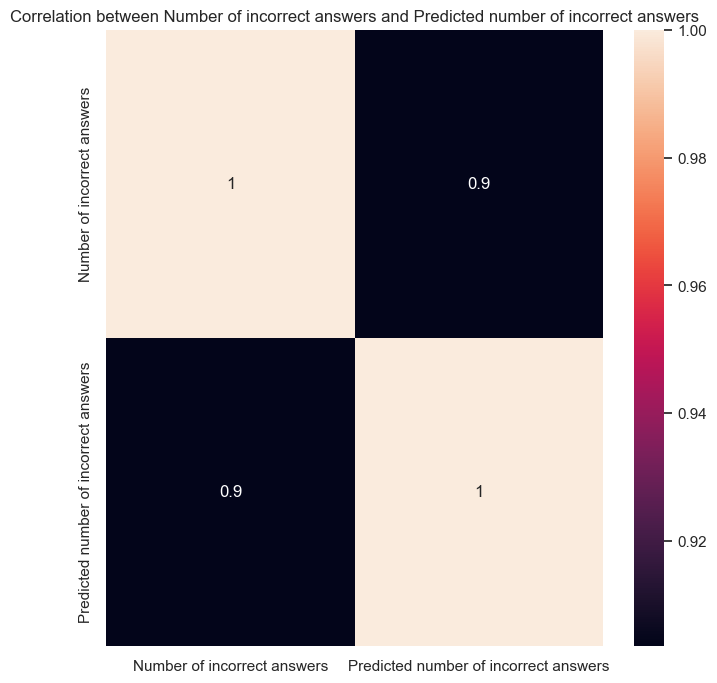

In [6]:
# Check if there is a correlation between no_of_occurrence and no_of_occurrence_future variables
# Select the columns to plot
columns_to_plot = ["RelatedLesson","no_of_occurance","no_of_occurance_future"]
# Rename the columns to new names
new_column_names = ["Related Lesson", "Number of incorrect answers", "Predicted number of incorrect answers"]
dataset_renamed = dataset[columns_to_plot].rename(columns=dict(zip(columns_to_plot, new_column_names)))

# Create and customize the heatmap plot
sns.set(rc={'figure.figsize': (8, 8)})
sns.set(font_scale=1)
sns.heatmap(dataset_renamed.corr(), annot=True)
plt.title('Correlation between Number of incorrect answers and Predicted number of incorrect answers')
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

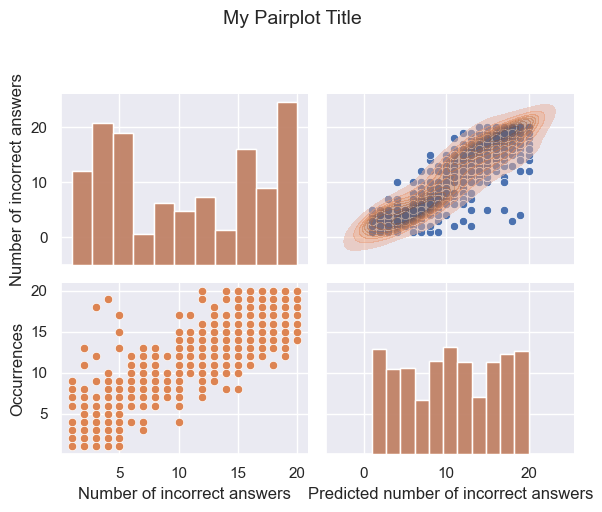

In [7]:
# Plot sns pair plot to visually represent the positive/negative correlation between the variables.
columns_to_plot = dataset[["RelatedLesson","no_of_occurance","no_of_occurance_future"]] \
                    .rename(columns={"RelatedLesson": "Lesson",
                                     "no_of_occurance": "Number of incorrect answers",
                                     "no_of_occurance_future": "Predicted number of incorrect answers"})
# Create and customize the pairplot
g = sns.pairplot(columns_to_plot, height=2.5, aspect=1.2)
g.fig.suptitle("My Pairplot Title", y=1.02, fontsize=14)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, kde=False)
g.map_upper(sns.kdeplot, fill=True, alpha=0.5)
g.fig.tight_layout(rect=[0, 0, 1, 0.96])
g.axes[1, 0].set_ylabel("Occurrences", fontsize=12)
g.axes[2, 0].set_ylabel("Future\nOccurrences", fontsize=12, rotation=0, labelpad=40)
plt.show()

In [8]:
X = dataset[["RelatedLesson","no_of_occurance"]]
y = dataset[["no_of_occurance_future"]]

In [9]:
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791 entries, 885 to 684
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   RelatedLesson    791 non-null    object
 1   no_of_occurance  791 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 18.5+ KB


In [11]:
# Exploring various lessons in the dataset
X_train["RelatedLesson"].value_counts()

data communication and networking         120
programming fundamentals                  105
data representation                        90
computer operating system                  79
database management                        78
introduction to computer                   74
fundamental of digital circuits            57
web development                            56
system analysis and design                 46
concept of it                              35
new trends and future directions of it     20
it in business                             18
internet of things                         13
Name: RelatedLesson, dtype: int64

Text(0, 0.5, 'Count of questions')

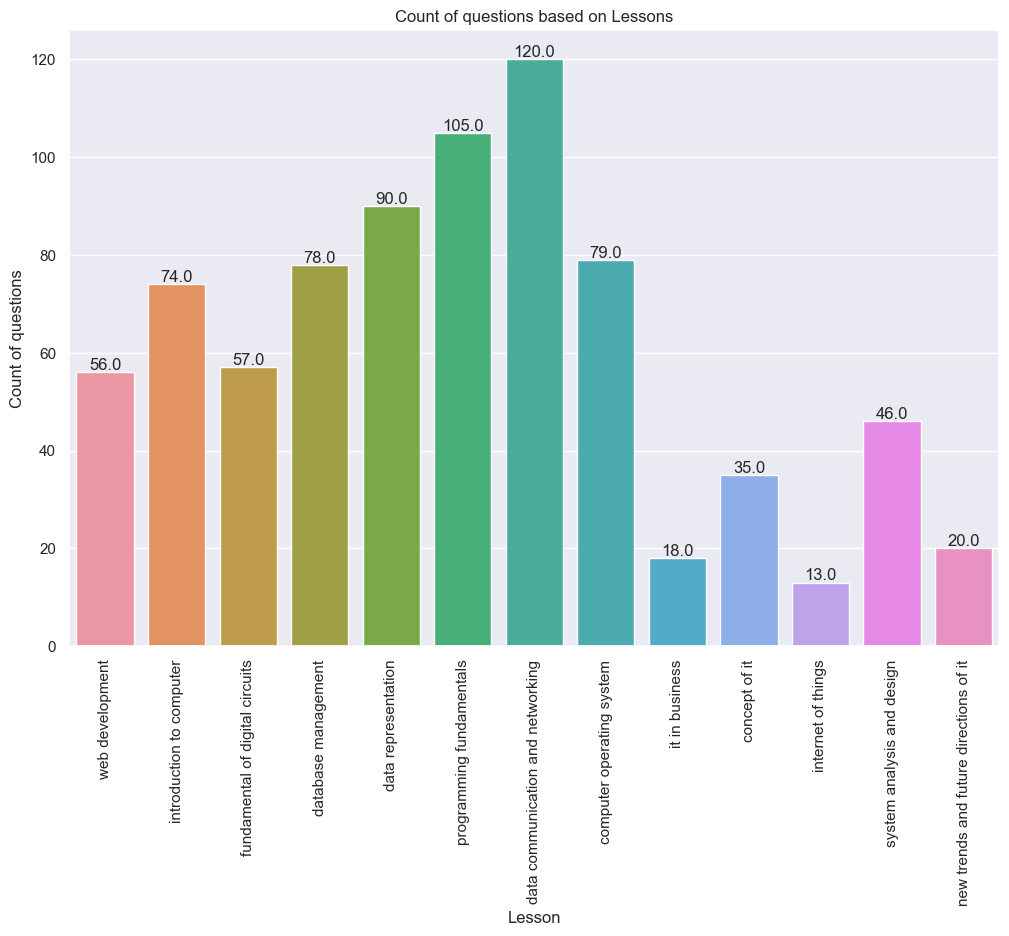

In [12]:
# Confirming that there are no null values and identify all the unique values
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'RelatedLesson', data = X_train)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(),
                        (p.get_x() + p.get_width() / 2.0,
                         p.get_height()),
                        ha = 'center',
                        va = 'center',
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of questions based on Lessons")
plt.xlabel("Lesson")
plt.ylabel("Count of questions")

In [13]:
# Creating dummy columns for the categorical columns
X_train = pd.get_dummies(X_train,
                         columns = ["RelatedLesson"],
                         drop_first = True)

X_test = pd.get_dummies(X_test,
                         columns = ["RelatedLesson"],
                         drop_first = True)

In [14]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test)

In [15]:
# Creating a linear regression model
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)
def regression_report(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    report = f'R^2 Score: {r2:.3f}\nMean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}'
    return report
report = regression_report(y_test, y_pred)
print(report)
# # R2 score and Mean Square Error(MSE)
# score = r2_score(y_test, y_pred)
# error = mean_squared_error(y_test,y_pred)
# print("The accuracy of the model is {}%".format(round(score,2) * 100))
# print("The Mean Absolute Error of our model is {}".format(round(error, 2)))

R^2 Score: 0.762
Mean Absolute Error: 2.087
Mean Squared Error: 7.638


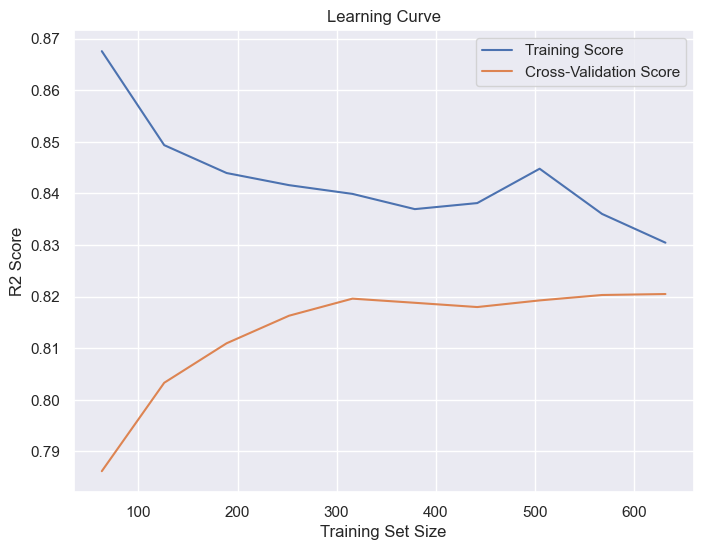

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    linearRegression, X_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

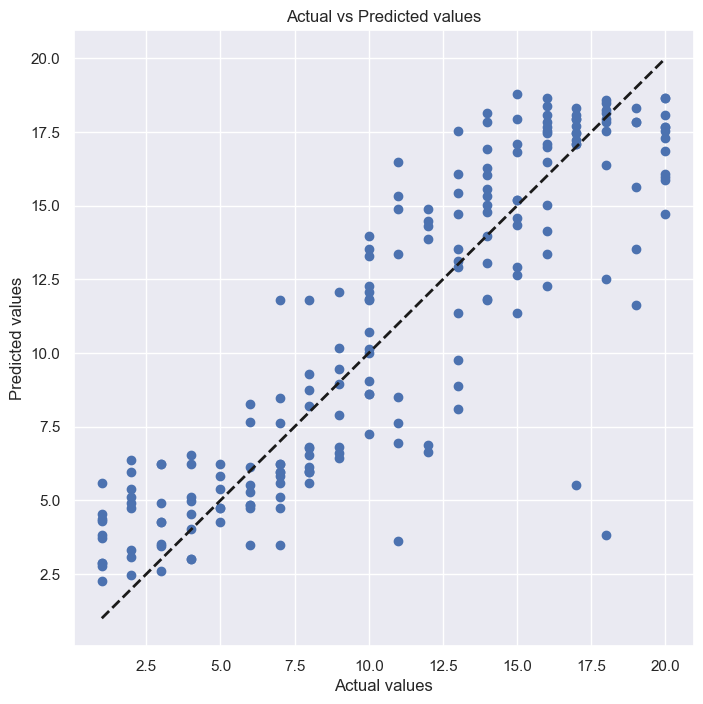

In [17]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted values")
plt.show()

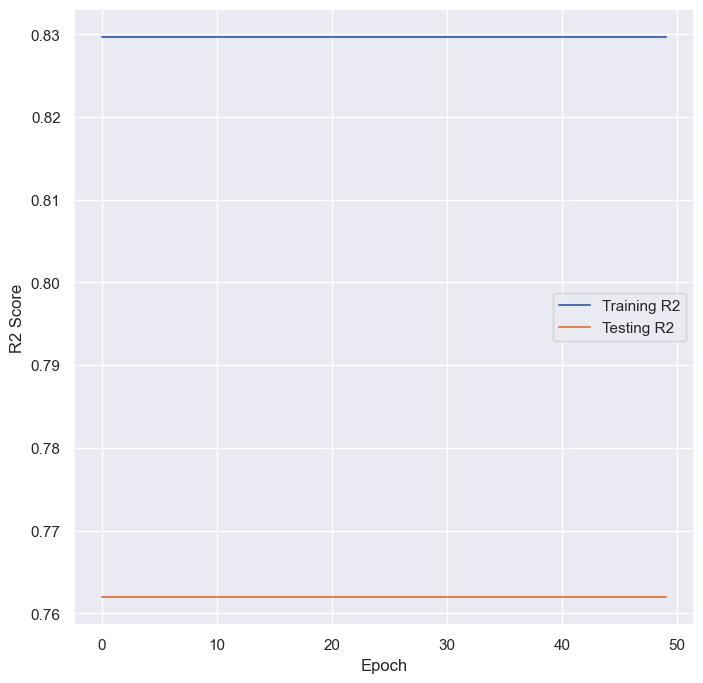

In [18]:
train_r2_scores = []
test_r2_scores = []
num_epochs = 50
for epoch in range(num_epochs):
    # Train your model on the training data for one epoch
    linearRegression.fit(X_train, y_train)

    # Calculate the R2 score for the training data
    y_train_pred = linearRegression.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    train_r2_scores.append(train_r2)

    # Calculate the R2 score for the testing data
    y_test_pred = linearRegression.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_r2_scores.append(test_r2)

# Plot the R2 score for each epoch
plt.plot(range(num_epochs), train_r2_scores, label='Training R2')
plt.plot(range(num_epochs), test_r2_scores, label='Testing R2')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()
plt.show()


In [ ]:
# Creating a function to use the model
def useModel(lessonName, noOfQuestionsAnsweredIncorrectly):
    # Reading the csv file for prediction
    df1 = pd.read_csv('table_to_use_in_the_model_for_prediction.csv')
    df1.loc[len(df1.index)] = [lessonName,noOfQuestionsAnsweredIncorrectly]
    indexNum = len(df1.index)-1
    # Creating dummy columns for the categorical columns
    df1 = pd.get_dummies(df1,
                         columns = ["RelatedLesson"],
                         drop_first = True)

    global standardScaler
    df1 = standardScaler.transform(df1)

    global linearRegression
    return np.round(linearRegression.predict(df1)[indexNum])


In [ ]:
useModel("internet of things", 15)